In [1]:
!pip install patchify albumentations  > /dev/null 
!pip install -q -U segmentation-models > /dev/null 
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import albumentations as album
from patchify import patchify
import utils
import utils_cityscapes as utils_cs
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss, BinaryFocalLoss
from segmentation_models.losses import cce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models.metrics import FScore

Segmentation Models: using `tf.keras` framework.


In [ ]:
DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'
PATCH_HEIGHT = 500
PATCH_WIDTH = 500

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

# [0, 0, 0] -> background [255, 255, 255] -> Buldings

class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
train_images_paths, mask_images_paths = utils.get_images_paths(x_train_dir, y_train_dir)

In [ ]:
train_images_paths, mask_images_paths = utils.get_images_paths(x_train_dir, y_train_dir)
val_images_paths, val_masks_paths = utils.get_images_paths(x_valid_dir, y_valid_dir)
test_images_paths, test_masks_paths = utils.get_images_paths(x_test_dir, y_test_dir)

trans_aug_fn = utils.get_training_augmentation(prob=0.4)
train_images, train_masks = utils.load_preprocess_images(train_images_paths, mask_images_paths,
                                                         (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2,
                                                         class_rgb_values, trans_aug_fn)
train_images = np.array(train_images)
train_masks = np.array(train_masks)

val_images, val_masks = utils.load_preprocess_images(val_images_paths, val_masks_paths,
                                                     (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)
val_images = np.array(val_images)
val_masks=np.array(val_masks)

In [ ]:
idx=np.random.randint(len(train_images))
print(idx)
utils.visualize(
        original_image = train_images[idx],
        ground_truth_mask = utils.colour_code_segmentation(utils.reverse_one_hot(train_masks[idx]), select_class_rgb_values),
        one_hot_encoded_mask = utils.reverse_one_hot(train_masks[idx])
    )
plt.show()

In [ ]:
import tensorflow.keras.backend as K

ALPHA = 0.7
GAMMA = 0.75

def tversky(y_true, y_pred, smooth=1, alpha=0.8):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + ALPHA * false_neg + (1 - ALPHA) * false_pos + smooth)


def tversky_loss(y_true, y_pred, alpha=0.75):
    return 1 - tversky(y_true, y_pred, alpha=ALPHA)


def focal_tversky_loss(y_true, y_pred, gamma=0.75, alpha=0.8):
    tv = tversky(y_true, y_pred, alpha=ALPHA)
    return K.pow((1 - tv), GAMMA)

In [ ]:
ENCODER = 'vgg16' #vgg16
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'
BATCH_SIZE=12
EPOCHS=40

model = Unet(
    ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    encoder_freeze = True
)

preprocessing_fn = sm.get_preprocessing(ENCODER)

######################### OPTIMIZER ####################
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True, name="SGD" )
optimizer = keras.optimizers.Adam(learning_rate=0.001)

fs= FScore()
model.compile(optimizer=optimizer, loss=tversky_loss, metrics=[iou_score, fs, tversky])

In [ ]:
train_images = preprocessing_fn(train_images)
val_images = preprocessing_fn(val_images)

In [ ]:
hist = []

In [ ]:
hist.append(model.fit(x=train_images, y=train_masks,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    validation_data=(val_images, val_masks)).history)

In [ ]:
print('tversky: {0} \t f1-score: {1} \t iou-score: {2} \t loss: {3}'.format(hist[0]['val_tversky'][-1], hist[0]['val_f1-score'][-1],
                                                                            hist[0]['val_iou_score'][-1], hist[0]['val_loss'][-1]) )

In [ ]:
idx = 6
fig, axes = plt.subplots(1, 2, figsize=(20,8))
losses_measures = {k: hist[idx][k] for k in ('loss', 'val_loss')}
metric_measures = hist[idx].copy()
metric_measures.pop('loss')
metric_measures.pop('val_loss')

pd.DataFrame(losses_measures).plot(ax=axes[0])
pd.DataFrame(metric_measures).plot(ax=axes[1])

plt.savefig('./build-40-bce-IOU-f1-12batch.png')
plt.show()

In [ ]:
#dir_weights='../input/buildingweights/weights-unet-satellite_10_64.h5'
#model.save_weights(f'./weights-unet-satellite_tversky_{EPOCHS}_{BATCH_SIZE}.h5')
model.load_weights(f'../input/buildingweights/weights-unet-satellite_tversky_{EPOCHS}_{BATCH_SIZE}.h5')

In [ ]:
test_images_paths, test_masks_paths = utils.get_images_paths(x_test_dir, y_test_dir)
test_images, test_masks = utils.load_preprocess_images(test_images_paths, test_masks_paths, (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)
test_images = np.array(test_images)
test_images_real = test_images.copy()
test_masks = np.array(test_masks)
preprocessing_fn = sm.get_preprocessing(ENCODER)
test_images = preprocessing_fn(test_images)

In [ ]:
model.evaluate(test_images, test_masks)

In [ ]:
pred = model.predict(test_images)

In [ ]:
#idx = np.random.randint(len(test_images))
for idx in [9, 31, 32, 81, 74, 6, 24, 64]:
    print(idx)
    utils.visualize(
            original_image = test_images_real[idx],
            ground_truth = utils.reverse_one_hot(test_masks[idx]),
            pred_mask = utils.reverse_one_hot(pred[idx])
        )
    plt.savefig(f'./pred_img_unet-satellite_tversky_{idx}.png')

## CityScapes

In [3]:
DATA_DIR = '../input/cityscape/'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/annotations')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/annotations')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/annotations')


ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
class_values = utils_cs.grouped_labels

N_CLASSES = len(class_values)+1

ACTIVATION = 'softmax'
BATCH_SIZE = 32
EPOCHS = 40

model = Unet(ENCODER, encoder_weights=ENCODER_WEIGHTS, classes=N_CLASSES, activation=ACTIVATION,
         encoder_freeze = True)
optimizer = keras.optimizers.Adam(1e-3) # to test SGD
#optimizer = keras.optimizers.SGD(1e-1, momentum=0.9, nesterov=True)
preprocessing_fn = sm.get_preprocessing(ENCODER)

fs= FScore()
model.compile(optimizer=optimizer, loss=cce_jaccard_loss, metrics=[iou_score, fs])

training_dataset = utils_cs.Dataset(x_train_dir, y_train_dir, class_values=class_values,
                 preprocessing=utils_cs.get_preprocessing(preprocessing_fn))

valid_dataset = utils_cs.Dataset(x_valid_dir, y_valid_dir, class_values=class_values,
                 preprocessing=utils_cs.get_preprocessing(preprocessing_fn))

train_dataloader = utils_cs.Dataloder(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = utils_cs.Dataloder(valid_dataset, batch_size=1, shuffle=False)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
mask_example = training_dataset.__getitem__(1)[1] #get item retrieve a mask with shape [256, 256, len(grouped_labels)+1]

mask_example = training_dataset.convert_to_single_mask(mask_example) #convert it to [256, 256] each cell made of the specific grouped_labels 
result = utils_cs.colour_code_segmentation(mask_example) #colour the mask by using the dictionary, group_label -> pixel
plt.imshow(result)
plt.show()

In [4]:
history=[]

In [14]:
optimizer = keras.optimizers.Adam(1e-4) 
model.compile(optimizer=optimizer, loss=cce_jaccard_loss, metrics=[iou_score, fs])


In [15]:
# train model
history.append(model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
).history)

Epoch 1/20
35/35 [==============================] - 135s 4s/step - loss: 0.2070 - iou_score: 0.8225 - f1-score: 0.8950 - val_loss: 0.5163 - val_iou_score: 0.5801 - val_f1-score: 0.6789
Epoch 2/20
35/35 [==============================] - 132s 4s/step - loss: 0.2004 - iou_score: 0.8284 - f1-score: 0.8994 - val_loss: 0.5179 - val_iou_score: 0.5784 - val_f1-score: 0.6773
Epoch 3/20
35/35 [==============================] - 131s 4s/step - loss: 0.1928 - iou_score: 0.8343 - f1-score: 0.9031 - val_loss: 0.5144 - val_iou_score: 0.5808 - val_f1-score: 0.6802
Epoch 4/20
35/35 [==============================] - 131s 4s/step - loss: 0.1970 - iou_score: 0.8317 - f1-score: 0.9016 - val_loss: 0.5186 - val_iou_score: 0.5781 - val_f1-score: 0.6780
Epoch 5/20
35/35 [==============================] - 132s 4s/step - loss: 0.1971 - iou_score: 0.8314 - f1-score: 0.9014 - val_loss: 0.5199 - val_iou_score: 0.5778 - val_f1-score: 0.6777
Epoch 6/20
35/35 [==============================] - 131s 4s/step - loss: 0.

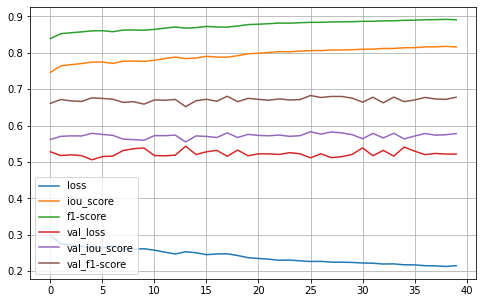

In [19]:
pd.DataFrame(history[0]).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [27]:
dir_weights = './'
model.save_weights(f'{dir_weights}/weights-unet-cityscape_{100}_{BATCH_SIZE}.h5')

In [6]:
dir_weights = '../input/buildingweights'
#model.save_weights(f'{dir_weights}/weights-unet-cityscape_{EPOCHS}_{BATCH_SIZE}.h5')
model.load_weights(f'{dir_weights}/weights-unet-cityscape_{EPOCHS}_{BATCH_SIZE}.h5')

In [30]:
test_dataset = utils_cs.Dataset(x_test_dir, y_test_dir, class_values=class_values, preprocessing=utils_cs.get_preprocessing(preprocessing_fn))
test_dataloader = utils_cs.Dataloder(test_dataset, batch_size=1, shuffle=False)
evaluation = model.evaluate(test_dataloader)
pred = model.predict(test_dataloader)
result = np.argmax(pred,axis=3)

472/472 [==============================] - 44s 94ms/step - loss: 0.5133 - iou_score: 0.5847 - f1-score: 0.6778


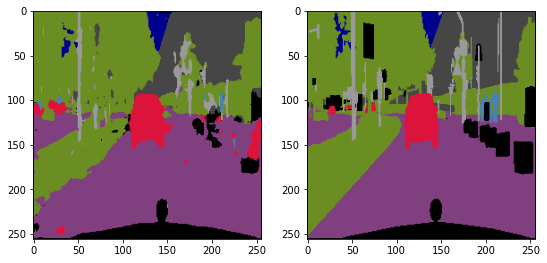

In [29]:
idx = np.random.randint(len(test_dataset))

res_seg = utils_cs.colour_code_segmentation(result[idx]) #colour the mask by using the dictionary, group_label -> pixel

mask_example = test_dataset.__getitem__(idx)[1]
mask_example = test_dataset.convert_to_single_mask(mask_example) 
result_example = utils_cs.colour_code_segmentation(mask_example)

fig, axes = plt.subplots(1, 2,figsize=(9,6))
_ = axes[0].imshow(res_seg)
_ = axes[1].imshow(result_example)
plt.show()